In [49]:
import numpy as np
import pandas as pd
import yfinance as yf

https://mofc.unic.ac.cy/the-m6-competition/

In [257]:
assets = pd.read_csv("https://storage.googleapis.com/m6-bucket-webapp-public/M6_Universe.csv")
display(assets.head())

,id,class,symbol,name,GICS_sector/ETF_type,GICS_industry/ETF_subtype
0,1,Stock,ABBV,AbbVie,Health Care,Pharmaceuticals
1,2,Stock,ACN,Accenture,Information Technology,IT Consulting & Other Services
2,3,Stock,AEP,American Electric Power,Utilities,Electric Utilities
3,4,Stock,AIZ,Assurant,Financials,Multi-line Insurance
4,5,Stock,ALLE,Allegion,Industrials,Building Products


In [256]:
df = yf.download(list(assets['symbol'].values))
display(df.head())

[*********************100%***********************]  100 of 100 completed


Adj Close                                               ... Volume  \
                ABBV ACN       AEP AIZ ALLE AMAT AMP AMZN AVB AVY  ...    XLC   
Date                                                               ...          
1962-01-02       NaN NaN  1.035685 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   
1962-01-03       NaN NaN  1.033799 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   
1962-01-04       NaN NaN  1.018706 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   
1962-01-05       NaN NaN  0.996069 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   
1962-01-08       NaN NaN  0.988523 NaN  NaN  NaN NaN  NaN NaN NaN  ...    NaN   

                                                       
           XLE XLF XLI XLK XLP XLU XLV XLY        XOM  
Date                                                   
1962-01-02 NaN NaN NaN NaN NaN NaN NaN NaN   902400.0  
1962-01-03 NaN NaN NaN NaN NaN NaN NaN NaN  1200000.0  
1962-01-04 NaN NaN NaN NaN NaN NaN NaN NaN  1088000.0  
1962-01-05 NaN NaN NaN NaN NaN NaN NaN NaN  1222400.0  
1962-01-08 NaN NaN NaN NaN NaN NaN NaN NaN  1388800.0  

[5 rows x 600 columns]

# Features

In the naive setup, consider long dataframes of the form

$$(N \times T) \text{ rows } \times F \text{ columns }$$

The label to predict is the relative ranking of asset returns in the next timestep

In [29]:
import lightgbm as lgb

In [261]:
# Make Dataframe

START_DATE = "2010-01-01"

df_filtered = df.loc[df.index > START_DATE, 'Adj Close']

test = np.log(df_filtered).diff(1).iloc[:, 1:4].iloc[-500:-1].dropna()
test_ranks = test.apply(lambda x: x.argsort(), axis = 1).shift(-1)

df2 = pd.concat([test, test_ranks], axis = 1).iloc[:-1]
df2.iloc[:, -3:] = df2.iloc[:, -3:].astype(int)

# Turn to LONG format
df3 = pd.DataFrame()
for i in range(1, 4):
    temp = pd.concat([df2.iloc[:, 0:-3], df2.iloc[:, -i]], axis = 1)
    temp.columns = list(temp.columns)[:-1] + ["rank"]
    temp['asset'] = df2.columns[-i]
    df3 = pd.concat([df3, temp])

df3 = df3.reset_index('Date').sort_values(by='Date').reset_index(drop=True)

df3['asset'] = df3['asset'].astype("category")

display(df3)

,Date,ACN,AEP,AIZ,rank,asset
0,2020-03-09,-0.085451,-0.028446,-0.093098,0,AIZ
1,2020-03-09,-0.085451,-0.028446,-0.093098,1,ACN
2,2020-03-09,-0.085451,-0.028446,-0.093098,2,AEP
3,2020-03-10,0.061732,-0.002531,0.043427,2,AIZ
4,2020-03-10,0.061732,-0.002531,0.043427,0,ACN
...,...,...,...,...,...,...
1429,2022-02-09,0.029862,-0.000447,0.065243,1,AIZ
1430,2022-02-09,0.029862,-0.000447,0.065243,2,AEP
1431,2022-02-10,-0.037659,-0.022516,-0.024247,2,AEP
1432,2022-02-10,-0.037659,-0.022516,-0.024247,1,AIZ


# Model

In the naive model, apply LGBRanker to predict the rankings of asset returns in the next timestep


In [264]:
lgbr = lgb.LGBMRanker(n_estimators=100)
lgbr.fit(df3.iloc[:, [1,2, 3, 5]], df3.iloc[:, 4], group = [df3.shape[0] / 3] * 3)

LGBMRanker()

In [265]:
preds = lgbr.predict(df3.iloc[:, [1,2, 3, 5]], raw_score=False)

In [274]:
pred_ranks = pd.DataFrame(preds.reshape(-1, 3))
pred_ranks.columns = test_ranks.columns
pred_ranks.index = list(test_ranks.index)[:-1]

<AxesSubplot:>

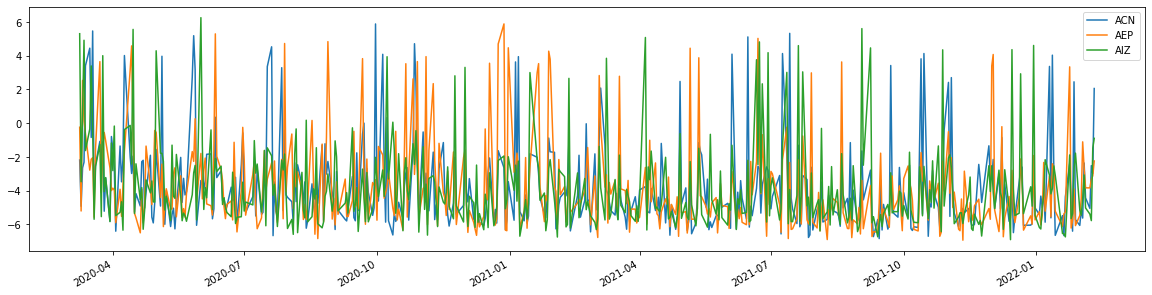

In [279]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 5))
pred_ranks.plot(ax = ax)

## Metrics

In [ ]:
from sklearn.metrics import ndcg_score

Normalised Cumulative Discounted Gain: A perfect score procues a ranking of 1

In [254]:
ndcg_score(test_ranks.iloc[:-1].values, pred_ranks.apply(lambda x: x.argsort(), axis = 1))

0.8041598049622952

# Portfolio

Map Predictions (Ranks, Probabilities) to weights via some function


$$f(\hat{y}_{t}) \rightarrow w_{t}$$

Maximise the *information ratio* of our portfolio

$$E[R_{p, t}] / SD(R_{p, t}), R_{p, t} = w_{t} \cdot R_{t}$$



In [289]:
from scipy.special import softmax
weights = pred_ranks.apply(lambda x: x.argsort(), axis = 1).apply(lambda x: softmax(x), axis = 1)

In [312]:
weights

,ACN,AEP,AIZ
2020-03-09,0.090031,0.244728,0.665241
2020-03-10,0.244728,0.090031,0.665241
2020-03-11,0.090031,0.665241,0.244728
2020-03-12,0.090031,0.244728,0.665241
2020-03-13,0.665241,0.244728,0.090031
...,...,...,...
2022-02-04,0.665241,0.090031,0.244728
2022-02-07,0.665241,0.090031,0.244728
2022-02-08,0.665241,0.244728,0.090031
2022-02-09,0.244728,0.090031,0.665241


In [310]:
rets = (weights * (np.exp(test.shift(-1)) - 1)).sum(axis = 1)
display(rets)

2020-03-09    0.034640
2020-03-10   -0.050185
2020-03-11   -0.086674
2020-03-12    0.074440
2020-03-13   -0.087195
                ...   
2022-02-07    0.007825
2022-02-08    0.026125
2022-02-09   -0.026985
2022-02-10   -0.007817
2022-02-11    0.000000
Length: 479, dtype: float64

<AxesSubplot:>

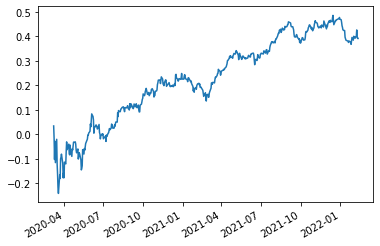

In [307]:
rets.cumsum().plot()